In [1]:
import TensorFrost as tf
import numpy as np
import matplotlib.pyplot as plt
import time

tf.initialize(tf.cpu, "/O2 /fp:fast /openmp")

N = 256
M = 512

def WaveIteration(u, v, dt):
    i,j = u.indices
    laplacian = u[i-1, j] + u[i+1, j] + u[i, j-1] + u[i, j+1] - u[i,j] * 4.0
    force = laplacian - 0.1 * tf.sin(2.0*np.pi*u)
    v_new = v + dt*force
    u_new = u + dt*v_new
    return u_new, v_new

def WaveEq():
    u = tf.input([-1, -1], tf.float32)
    v = tf.input([-1, -1], tf.float32)

    u,v = WaveIteration(u, v, 0.2)

    return [u, v]

test = tf.program(WaveEq)


TensorFrost module loaded!
TensorProgram:
  Kernel count: 3
  Intermediate buffers: 7
  Lines of generated code: 147
  IR size: 273



In [5]:
test.list_operations()

List of operations:

mem0 = memory(type=int)
mem1 = memory(type=int)

mem2 = memory(shape=[mem0,mem1], memory_type=input, type=float)
mem3 = memory(type=int)
mem4 = memory(type=int)

mem5 = memory(shape=[mem3,mem4], memory_type=input, type=float)

mem6 = memory(shape=[mem0,mem1], type=float)

var5_0 = dim_id(shape=[mem0,mem1], data=[0], type=int)
var5_1 = dim_id(shape=[mem0,mem1], data=[1], type=int)
var5_3 = sub(inputs=[var5_0,1], shape=[mem0,mem1], cost=1.000000, type=int)
var5_5 = add(inputs=[var5_0,1], shape=[mem0,mem1], cost=1.000000, type=int)
var5_7 = sub(inputs=[mem0,1], cost=1.000000, type=int)
var5_9 = clamp(inputs=[var5_3,0,var5_7], shape=[mem0,mem1], cost=6.000000, type=int)
var5_10 = mul(inputs=[var5_9,mem1], shape=[mem0,mem1], cost=7.000000, type=int)
var5_12 = sub(inputs=[mem1,1], cost=1.000000, type=int)
var5_14 = clamp(inputs=[var5_1,0,var5_12], shape=[mem0,mem1], cost=5.000000, type=int)
var5_15 = add(inputs=[var5_10,var5_14], shape=[mem0,mem1], cost=13.000000, type=i

In [2]:
#do a few steps and measure performance by timing every 100 steps
import time
import imageio
from IPython.display import Image
import os

start = time.time()

file_path = 'H:/TestVideos/wave.gif'

#remove file if it exists

if os.path.isfile(file_path):
    os.remove(file_path)

writer = imageio.get_writer(file_path, mode='I', fps=30, loop=0)

x = np.arange(M)
y = np.arange(N)
X,Y = np.meshgrid(x, y)
Anp = np.exp(-((X-M/2)**2 + (Y-N/2+50)**2)/(10**2))
Anp += np.exp(-((X-M/2-50)**2 + (Y-N/2-50)**2)/(10**2))
Bnp = np.zeros((N, M))

A = tf.memory(Anp)
B = tf.memory(Bnp)

print("Used memory: " + str(tf.used_memory()))

iters = 1000

for i in range(iters):
    A, B = test(A, B)
    if(i % 50 == 0):
        frame = A.numpy
        frame = np.clip(np.abs(3.0 * frame * 255), 0, 255).astype(np.uint8)
        writer.append_data(frame)
    if i % 100 == 99:
        print("Iterations per second: " + str(100/(time.time()-start)))
        start = time.time()


writer.close()

print("Used memory: " + str(tf.used_memory()))

Used memory: 262144
Iterations per second: 970.9149411451522
Iterations per second: 2000.0019073504518
Iterations per second: 1999.9828340096415
Iterations per second: 2173.9466659755876
Iterations per second: 2325.556535094285
Iterations per second: 2438.988422331932
Iterations per second: 2325.6210078069553
Iterations per second: 2564.1316574558614
Iterations per second: 2325.556535094285
Iterations per second: 2439.0309712385006
Used memory: 393220


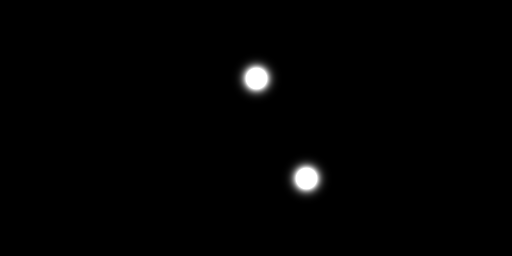

In [3]:
#display the gif
Image(filename=file_path)

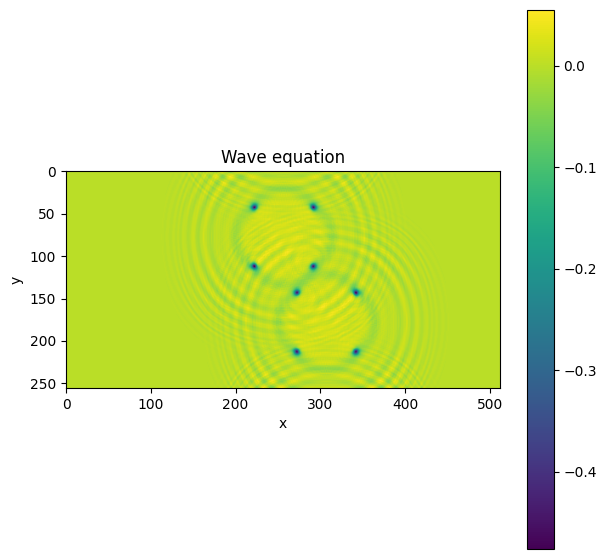

In [4]:
# Plot the results (with colorbar)
plt.figure(figsize=(7,7))
plt.imshow(A.numpy)
plt.colorbar()
plt.title("Wave equation")
plt.xlabel("x")
plt.ylabel("y")
plt.show()